In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
print(os.path.abspath(""))
sys.path.append(os.path.abspath("") + "/../src/pynirs")
from nirs_set import NIRS_Set as NSet
import preprocessor as pp
import matplotlib.pyplot as plt


n = NSet("example")
n.load("sample_data/XCal.csv", "sample_data/YCal.csv", 0, 0, 0)
x_src = n.get_raw_x()[0:10, :]
print(x_src.nbytes)
# print(x)
feature_count = len(x_src[0])
sample_count = len(x_src)
if feature_count%2 != 0:
    new_col = x_src[:, -1]
    xx_src = np.c_[x_src, new_col]
print("X", x_src.shape)
feature_count = len(x_src[0])

d:\Workspace\ML\pynirs\examples
86040
X (10, 2151)


In [ ]:
import pywt
import scipy.signal as signal
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import preprocessor as pp

x = x_src.copy()
methods = pp.METHOD_DICT

all_methods = []

plt.rcParams['figure.figsize'] = [30, 6*(len(methods)+1)]
l = np.arange(0, feature_count, 1)
fig, AX = plt.subplots(len(methods)+1,2)

# xx = pp.spl_norml(x)
all_methods.append('x')

xd = pp.detrend(x)
# xdn = pp.spl_norml(xd)
all_methods.append('detrend')

for i,xp in enumerate(xx):
    AX[0,0].plot(l, xp)
    AX[0,0].title.set_text("X")
    AX[0,1].plot(l, xdn[i])
    AX[0,1].title.set_text("Detrend")

## Clean source
x = RobustScaler().fit_transform(x)
first_order = []
for i, (k, f) in enumerate(methods.items()):
    all_methods.append('x-'+k)
    first_order.append('x-'+k)
    xps = f(x)
    xps = pp.spl_norml(xps)
    print(k, xps.shape)
    for xp in xps:
         AX[i+1,0].plot(l, xp)
         AX[i+1,0].title.set_text(k)
         
## detrend source
x = RobustScaler().fit_transform(xd)
for i, (k, f) in enumerate(methods.items()):
    all_methods.append('detrend-'+k)
    xps = f(x)
    xps = pp.spl_norml(xps)
    print(k, xps.shape)
    for xp in xps:
         AX[i+1,1].plot(l, xp)
         AX[i+1,1].title.set_text(k)
    
for i, (k, f) in enumerate(methods.items()):
    for fo in first_order:
        all_methods.append(fo+'-'+k)


### Wavelets
# methods = pp.WV_LIST
# # print(methods)
# fig, AX = plt.subplots( (len(methods)//3) + 1,3)
# plt.rcParams['figure.figsize'] = [30, 2*(len(methods)+1)]

# l = np.arange(0, feature_count, 1)

# for i, w in enumerate(methods):
#     all_methods.append('wv_'+w)
#     print(i, i//3, i%3, w)
#     wt_spectra = pp.wavelet_transform(x, w)
#     wt_spectra = RobustScaler().fit_transform(wt_spectra)
#     wt_spectra = pp.spl_norml(wt_spectra)
#     for xp in wt_spectra:
#         AX[i//3, i%3].plot(l, xp)
#         AX[i//3, i%3].title.set_text(w)

# print(all_methods)


In [3]:
import pywt
import scipy.signal as signal
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import preprocessor as pp
import threading, queue

pp_spectra = {}
q = queue.Queue()

def worker():
    while True:
        item = q.get()
        x = item['x']
        method_name = item['method_name']
        f = item['method']
        name = item['name']
        
        # print(f'Working on {name}')
        if method_name == 'wv':
            args = item['args']
            wt_spectra = pp.wavelet_transform(x, args)
            wt_spectra = RobustScaler().fit_transform(wt_spectra)
            wt_spectra = pp.spl_norml(wt_spectra)
            pp_spectra[name] = wt_spectra
            print(f'Finished WV {name}')
        else:
            xps = f(x)
            xps = pp.spl_norml(xps)
            pp_spectra[name] = xps
            print(f'Finished {name}')
        q.task_done()

# turn-on the worker thread
threading.Thread(target=worker, daemon=True).start()

x = x_src.copy()
all_methods = []

xx = pp.spl_norml(x)
all_methods.append('x')
pp_spectra['x'] = xx

xd = pp.detrend(x)
xdn = pp.spl_norml(xd)
all_methods.append('detrend')
pp_spectra['detrend'] = xdn


methods = pp.METHOD_DICT

## Clean source
first_order = []
for i, (k, f) in enumerate(methods.items()):
    name = 'x-'+k
    all_methods.append(name)
    first_order.append(name)
    q.put({
        'x': x,
        'name': name,
        'method_name': k,
        'method': f
    })

## detrend source
for i, (k, f) in enumerate(methods.items()):
    name = 'detrend-'+k
    all_methods.append(name)
    q.put({
        'x': xdn,
        'name': name,
        'method_name': k,
        'method': f
    })

### Wavelets
methods = pp.WV_LIST
for i, w in enumerate(methods):
    name = w
    all_methods.append(name)
    q.put({
        'x': x,
        'name': name,
        'method_name': 'wv',
        'method': None,
        'args': w
    })

q.join()
print('First order preprocessing done')


### 2nd order preprocessing
methods = pp.METHOD_DICT

for i, (k, f) in enumerate(methods.items()):
    for fo in first_order:
        name = fo+'-'+k
        all_methods.append(name)
        q.put({
            'x': pp_spectra[fo],
            'name': name,
            'method_name': k,
            'method': f
        })

q.join()
print('Second order preprocessing done')
print(all_methods)

for k, v in pp_spectra.items():
    print(k, v.shape)

Finished x-snv
Finished x-rnv
Finished x-savgol1


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-msc
Finished x-derivate
Finished x-gaussian1
Finished x-gaussian2
Finished detrend-snv
Finished detrend-rnv
Finished detrend-savgol1


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished detrend-msc
Finished detrend-derivate
Finished detrend-gaussian1
Finished detrend-gaussian2
Finished WV bior2.2
Finished WV bior3.1
Finished WV bior4.4
Finished WV bior5.5
Finished WV bior6.8
Finished WV coif1
Finished WV coif2
Finished WV coif3
Finished WV coif4
Finished WV coif5
Finished WV coif6
Finished WV coif7
Finished WV coif8
Finished WV coif9
Finished WV coif10
Finished WV coif11
Finished WV coif12
Finished WV coif13
Finished WV coif14
Finished WV coif15
Finished WV coif16
Finished WV coif17
Finished WV db2
Finished WV db3
Finished WV db4
Finished WV db5
Finished WV db6
Finished WV db7
Finished WV db8
Finished WV db9
Finished WV db10
Finished WV db11
Finished WV db12
Finished WV db13
Finished WV db14
Finished WV db15
Finished WV db16
Finished WV db17
Finished WV db18
Finished WV db19
Finished WV db20
Finished WV db21
Finished WV db22
Finished WV db23
Finished WV db24
Finished WV db25
Finished WV db26
Finished WV db27
Finished WV db28
Finished WV db29
Finished WV db30


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-snv-msc
Finished x-rnv-msc


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-savgol1-msc


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-msc-msc


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-derivate-msc


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-gaussian1-msc


d:\Workspace\ML\pynirsENV\lib\site-packages\sklearn\preprocessing\_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


Finished x-gaussian2-msc
Finished x-snv-derivate
Finished x-rnv-derivate
Finished x-savgol1-derivate
Finished x-msc-derivate
Finished x-derivate-derivate
Finished x-gaussian1-derivate
Finished x-gaussian2-derivate
Finished x-snv-gaussian1
Finished x-rnv-gaussian1
Finished x-savgol1-gaussian1
Finished x-msc-gaussian1
Finished x-derivate-gaussian1
Finished x-gaussian1-gaussian1
Finished x-gaussian2-gaussian1
Finished x-snv-gaussian2
Finished x-rnv-gaussian2
Finished x-savgol1-gaussian2
Finished x-msc-gaussian2
Finished x-derivate-gaussian2
Finished x-gaussian1-gaussian2
Finished x-gaussian2-gaussian2
Second order preprocessing done
['x', 'detrend', 'x-snv', 'x-rnv', 'x-savgol1', 'x-msc', 'x-derivate', 'x-gaussian1', 'x-gaussian2', 'detrend-snv', 'detrend-rnv', 'detrend-savgol1', 'detrend-msc', 'detrend-derivate', 'detrend-gaussian1', 'detrend-gaussian2', 'bior2.2', 'bior3.1', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9',

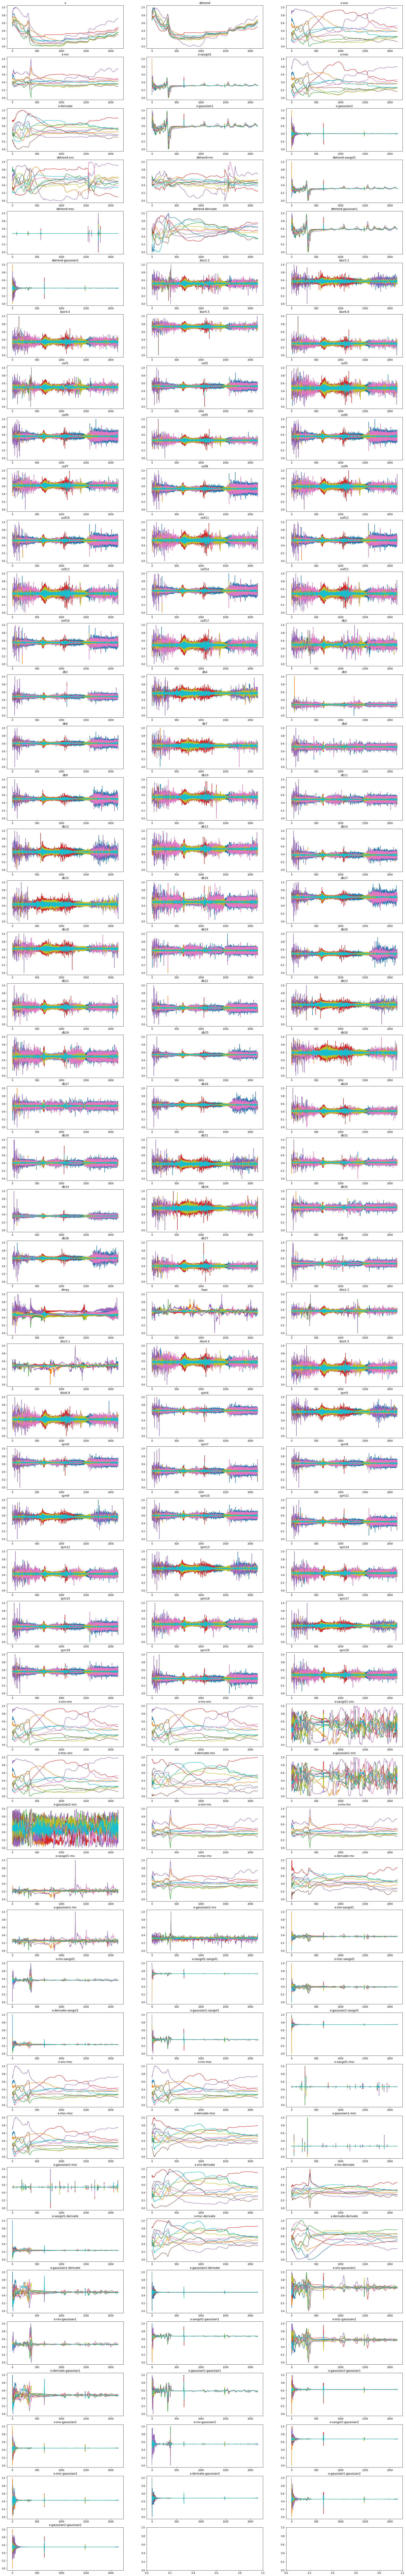

In [5]:
import numpy as np

plt.rcParams['figure.figsize'] = [30,25*(len(methods)+1)]
l = np.arange(0, feature_count, 1)
fig, AX = plt.subplots( (len(pp_spectra)//3)+1, 3 )
for i, (k, v) in enumerate(pp_spectra.items()):
    for x in v:
        AX[i//3, i%3].plot(l, x)
        AX[i//3, i%3].title.set_text(k) 




In [4]:
for k, v in pp_spectra.items():
    x = v[0]
    for l, w in pp_spectra.items():
        y = w[0]
        dist = np.linalg.norm(x-y)
        if dist < 0.001 and k != l:
            print(k, l, dist)

x-snv x-snv-snv 3.1542982e-06
x-snv x-rnv-snv 2.703864906839871e-06
x-snv x-msc-snv 3.3907263e-06
x-rnv x-snv-rnv 8.409795756753578e-07
x-rnv x-rnv-rnv 3.673567230414044e-07
x-rnv x-msc-rnv 1.7690531068374988e-06
x-snv-snv x-snv 3.1542982e-06
x-snv-snv x-rnv-snv 1.4261011164017984e-06
x-snv-snv x-msc-snv 2.1246046e-06
x-rnv-snv x-snv 2.703864906839871e-06
x-rnv-snv x-snv-snv 1.4261011164017984e-06
x-rnv-snv x-msc-snv 1.7481651988532502e-06
x-msc-snv x-snv 3.3907263e-06
x-msc-snv x-snv-snv 2.1246046e-06
x-msc-snv x-rnv-snv 1.7481651988532502e-06
x-snv-rnv x-rnv 8.409795756753578e-07
x-snv-rnv x-rnv-rnv 7.607766008238514e-07
x-snv-rnv x-msc-rnv 1.1462582362570184e-06
x-rnv-rnv x-rnv 3.673567230414044e-07
x-rnv-rnv x-snv-rnv 7.607766008238514e-07
x-rnv-rnv x-msc-rnv 1.7354300714947209e-06
x-msc-rnv x-rnv 1.7690531068374988e-06
x-msc-rnv x-snv-rnv 1.1462582362570184e-06
x-msc-rnv x-rnv-rnv 1.7354300714947209e-06
x-derivate-savgol1 x-savgol1-derivate 5.356356e-06
x-savgol1-derivate x-deriva